## __Data Balancing__
1. SMOTER Data Balancing
2. Train Test Split

In [1]:
## importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../data/final_dataset.csv')
df.head()

,OZONE_MAX,Lattitude,Longitude,PM10,PM2.5,SO2,NO2,CO,CO2,Temperature,AQI,AQI_CLASS
0,15.0,18.559427,73.828656,20.5,17.0,4.5,56.5,134.5,424.5,32.5,159.545072,Moderate
1,18.0,18.501727,73.813595,21.0,17.5,3.5,79.5,96.5,407.5,32.0,161.609099,Moderate
2,25.0,18.487306,73.885650,23.0,19.0,3.0,68.5,79.0,16.5,32.0,187.725451,Poor
3,5.0,18.501834,73.908639,23.5,19.5,5.5,107.5,111.5,454.5,32.0,165.737152,Moderate
4,9.0,18.451716,73.856170,17.5,15.0,4.5,89.0,82.0,51.5,32.5,157.481045,Moderate


In [3]:
y = df['AQI']
y_class = df['AQI_CLASS']
X = df.drop(columns=['AQI', 'AQI_CLASS'])

In [4]:
X_train, X_test, y_train, y_test, y_class_train, y_class_test = train_test_split(
    X, y, y_class, test_size=0.3, stratify=y_class, random_state=42, shuffle=True
)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [6]:
n_clusters = 100  # Define the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_clusters = kmeans.fit_predict(y_train.values.reshape(-1, 1))

In [7]:
X_train_clustered = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_clustered['AQI'] = y_train.values
X_train_clustered['cluster'] = y_clusters

In [8]:
# Identify minority clusters
cluster_sizes = X_train_clustered['cluster'].value_counts()
mean_size = cluster_sizes.mean()
minority_clusters = cluster_sizes[cluster_sizes < mean_size].index

In [20]:
# Step 2: Generate synthetic samples for minority clusters
synthetic_samples = []
target_values = []

for cluster in minority_clusters:
    cluster_data = X_train_clustered[X_train_clustered['cluster'] == cluster]
    cluster_features = cluster_data.drop(columns=['AQI', 'cluster']).values
    cluster_target = cluster_data['AQI'].values

    n_neighbors = 5
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(cluster_features)
    
    for i in range(len(cluster_features)):

        sample, neighbors = cluster_features[i], nbrs.kneighbors(cluster_features[i].reshape(1, -1), return_distance=False)
        neighbor = cluster_features[neighbors[0][np.random.randint(1, n_neighbors)]]
        
        # Linear interpolation between the sample and its neighbor
        synthetic_sample = sample + np.random.rand() * (neighbor - sample)
        synthetic_target = cluster_target[i] + np.random.normal(0, 0.5 * cluster_target.std())
        
        synthetic_samples.append(synthetic_sample)

        target_values.append(synthetic_target)

In [ ]:
synthetic_samples = scaler.inverse_transform(synthetic_samples)

In [ ]:
X_train_balanced = np.vstack((X_train, synthetic_samples))
y_train_balanced = np.hstack((y_train, target_values))

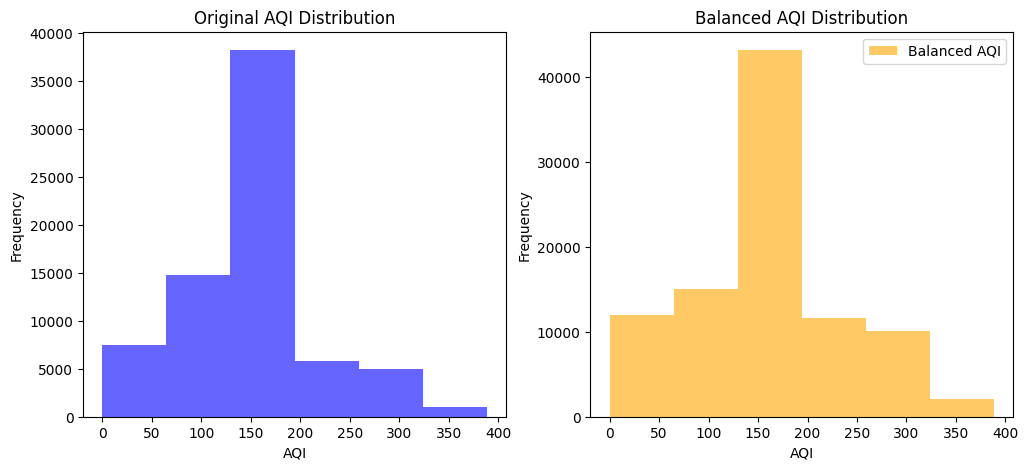

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
y_train.plot(kind='hist', bins=6, alpha=0.6, ax=ax[0], color='blue', label='Original AQI')
ax[0].set_title("Original AQI Distribution")
ax[0].set_xlabel("AQI")

# Balanced AQI Distribution after Custom SMOTER
pd.Series(y_train_balanced).plot(kind='hist', bins=6, alpha=0.6, ax=ax[1], color='orange', label='Balanced AQI')
ax[1].set_title("Balanced AQI Distribution")
ax[1].set_xlabel("AQI")

plt.legend()
plt.show()

In [ ]:
## saving the training and testing X and y csv files

X_train_balanced_df = pd.DataFrame(X_train_balanced, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
y_train_balanced_df = pd.DataFrame(y_train_balanced, columns=['AQI'])
y_test_df = pd.DataFrame(y_test, columns=['AQI'])

X_train_balanced_df.to_csv('../data/X_train_balanced.csv', index=False)
X_test_df.to_csv('../data/X_test.csv', index=False)
y_train_balanced_df.to_csv('../data/y_train_balanced.csv', index=False)
y_test_df.to_csv('../data/y_test.csv', index=False)

# __DELETE MODEL TRAINING PART FROM HERE ITS JUST TO CHECK STUFF__

In [134]:
X_train_balanced

array([[  8.        ,  18.51557   ,  73.8243931 , ...,  77.        ,
        415.        ,  32.5       ],
       [ 55.        ,  18.4822385 ,  73.8580916 , ...,  33.5       ,
          0.        ,  29.41538963],
       [ 52.        ,  18.4822385 ,  73.8580916 , ...,  40.5       ,
         23.        ,  28.5       ],
       ...,
       [ 55.        ,  18.4822385 ,  73.8580916 , ...,  53.5       ,
          0.        ,  29.41538963],
       [ 55.        ,  18.5017272 ,  73.8135954 , ...,  69.57172465,
        372.5237158 ,  27.17131014],
       [ 55.        ,  18.5017272 ,  73.8135954 , ...,  67.5       ,
        406.5       ,  28.        ]])

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=64, random_state=42)
rf_regressor.fit(X_train_balanced[0:1000], y_train_balanced[0:1000])

# Step 2: Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Step 3: Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display error metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)


feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': rf_regressor.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

c:\Users\Akhil PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Mean Absolute Error (MAE): 4.63184053827106
Mean Squared Error (MSE): 114.17752947689938
Root Mean Squared Error (RMSE): 10.685388597374425
R^2 Score: 0.9736408173469719
       feature  importance
0    OZONE_MAX    0.558920
4        PM2.5    0.375504
5          SO2    0.024102
8          CO2    0.013292
6          NO2    0.008515
7           CO    0.007779
3         PM10    0.005611
9  Temperature    0.003739
1    Lattitude    0.001576
2    Longitude    0.000961


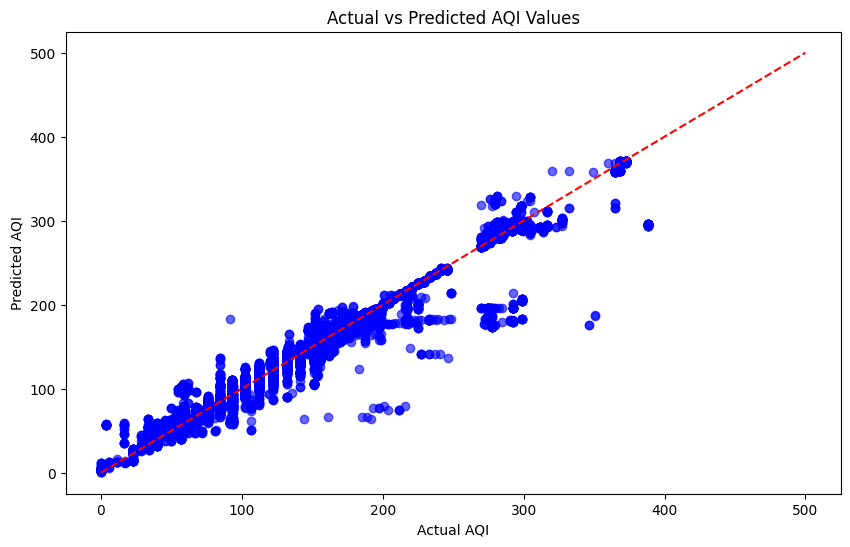

In [19]:
## plotting a scatter plot of predicted vs actual values

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([0, 500], [0, 500], color='red', linestyle='--')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI Values")
plt.show()